# 十字准线光标

这个示例添加了作为数据光标的十字准线。十字准线是通过在鼠标移动时更新的常规线条对象实现的。

我们展示了三种实现：

- 简易的光标实现，每次鼠标移动都会重绘图形。这有点慢，您可能会注意到十字准线移动的一些延迟。
- 使用双缓冲区加速渲染的光标。
- 能够对齐到数据点的光标。

使用原生 GUI 绘图可以实现更快的光标操作，例如[在 WX 中添加光标](../gui/wxcursor)。

[mpldatacursor](https://github.com/joferkington/mpldatacursor) 和 [mplcursors](https://github.com/anntzer/mplcursors) 这两个第三方包可以用来实现类似的效果。

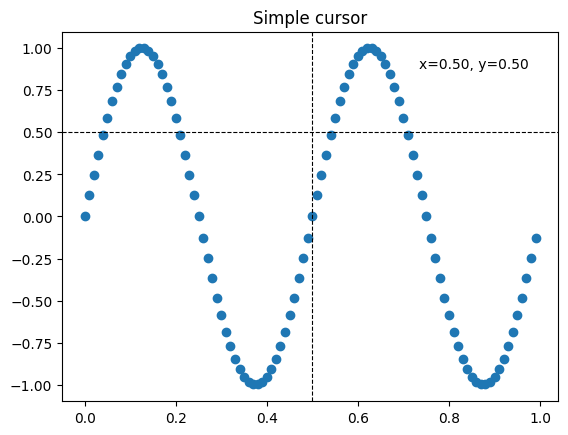

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.backend_bases import MouseEvent


class Cursor:
    """
    A cross hair cursor.
    """
    def __init__(self, ax):
        self.ax = ax
        self.horizontal_line = ax.axhline(color='k', lw=0.8, ls='--')
        self.vertical_line = ax.axvline(color='k', lw=0.8, ls='--')
        # text location in axes coordinates
        self.text = ax.text(0.72, 0.9, '', transform=ax.transAxes)

    def set_cross_hair_visible(self, visible):
        need_redraw = self.horizontal_line.get_visible() != visible
        self.horizontal_line.set_visible(visible)
        self.vertical_line.set_visible(visible)
        self.text.set_visible(visible)
        return need_redraw

    def on_mouse_move(self, event):
        if not event.inaxes:
            need_redraw = self.set_cross_hair_visible(False)
            if need_redraw:
                self.ax.figure.canvas.draw()
        else:
            self.set_cross_hair_visible(True)
            x, y = event.xdata, event.ydata
            # update the line positions
            self.horizontal_line.set_ydata([y])
            self.vertical_line.set_xdata([x])
            self.text.set_text(f'x={x:1.2f}, y={y:1.2f}')
            self.ax.figure.canvas.draw()


x = np.arange(0, 1, 0.01)
y = np.sin(2 * 2 * np.pi * x)

fig, ax = plt.subplots()
ax.set_title('Simple cursor')
ax.plot(x, y, 'o')
cursor = Cursor(ax)
fig.canvas.mpl_connect('motion_notify_event', cursor.on_mouse_move)

# Simulate a mouse move to (0.5, 0.5), needed for online docs
t = ax.transData
MouseEvent(
    "motion_notify_event", ax.figure.canvas, *t.transform((0.5, 0.5))
)._process()

## 使用双缓冲区加速重绘
此技术将渲染的绘图存储为背景图像。只有更改的艺术家（十字准线和文本）会被重新渲染。它们通过双缓冲区与背景组合。

这种方法速度显著提升。因为需要存储没有十字准线的背景（参见 {func}`create_new_background`），所以设置稍微复杂一些。此外，每当图形改变时，都需要创建一个新的背景。这是通过连接到  `'draw_event'` 实现的。

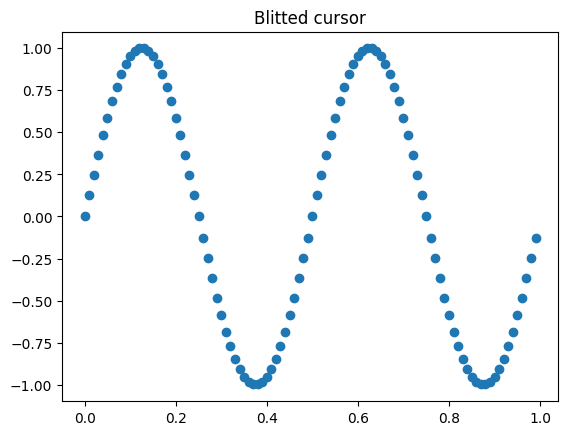

In [2]:
class BlittedCursor:
    """
    A cross-hair cursor using blitting for faster redraw.
    """
    def __init__(self, ax):
        self.ax = ax
        self.background = None
        self.horizontal_line = ax.axhline(color='k', lw=0.8, ls='--')
        self.vertical_line = ax.axvline(color='k', lw=0.8, ls='--')
        # text location in axes coordinates
        self.text = ax.text(0.72, 0.9, '', transform=ax.transAxes)
        self._creating_background = False
        ax.figure.canvas.mpl_connect('draw_event', self.on_draw)

    def on_draw(self, event):
        self.create_new_background()

    def set_cross_hair_visible(self, visible):
        need_redraw = self.horizontal_line.get_visible() != visible
        self.horizontal_line.set_visible(visible)
        self.vertical_line.set_visible(visible)
        self.text.set_visible(visible)
        return need_redraw

    def create_new_background(self):
        if self._creating_background:
            # discard calls triggered from within this function
            return
        self._creating_background = True
        self.set_cross_hair_visible(False)
        self.ax.figure.canvas.draw()
        self.background = self.ax.figure.canvas.copy_from_bbox(self.ax.bbox)
        self.set_cross_hair_visible(True)
        self._creating_background = False

    def on_mouse_move(self, event):
        if self.background is None:
            self.create_new_background()
        if not event.inaxes:
            need_redraw = self.set_cross_hair_visible(False)
            if need_redraw:
                self.ax.figure.canvas.restore_region(self.background)
                self.ax.figure.canvas.blit(self.ax.bbox)
        else:
            self.set_cross_hair_visible(True)
            # update the line positions
            x, y = event.xdata, event.ydata
            self.horizontal_line.set_ydata([y])
            self.vertical_line.set_xdata([x])
            self.text.set_text(f'x={x:1.2f}, y={y:1.2f}')

            self.ax.figure.canvas.restore_region(self.background)
            self.ax.draw_artist(self.horizontal_line)
            self.ax.draw_artist(self.vertical_line)
            self.ax.draw_artist(self.text)
            self.ax.figure.canvas.blit(self.ax.bbox)


x = np.arange(0, 1, 0.01)
y = np.sin(2 * 2 * np.pi * x)

fig, ax = plt.subplots()
ax.set_title('Blitted cursor')
ax.plot(x, y, 'o')
blitted_cursor = BlittedCursor(ax)
fig.canvas.mpl_connect('motion_notify_event', blitted_cursor.on_mouse_move)

# Simulate a mouse move to (0.5, 0.5), needed for online docs
t = ax.transData
MouseEvent(
    "motion_notify_event", ax.figure.canvas, *t.transform((0.5, 0.5))
)._process()

## 对齐到数据点

下面的光标将其位置对齐到 {class}`~matplotlib.lines.Line2D` 对象的数据点。

为了避免不必要的重绘，将最后指示的数据点的索引保存在 `self._last_index` 中。只有当鼠标移动足够远以至于必须选择另一个数据点时，才会触发重绘。这减少了由于多次重绘导致的延迟。当然，还可以在上面添加双缓冲区以进一步加速。

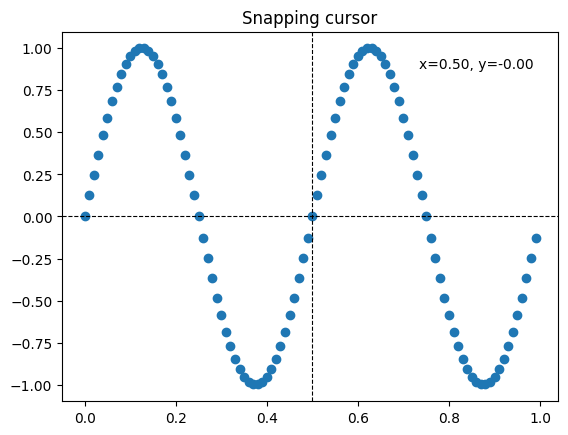

In [3]:
class SnappingCursor:
    """
    A cross-hair cursor that snaps to the data point of a line, which is
    closest to the *x* position of the cursor.

    For simplicity, this assumes that *x* values of the data are sorted.
    """
    def __init__(self, ax, line):
        self.ax = ax
        self.horizontal_line = ax.axhline(color='k', lw=0.8, ls='--')
        self.vertical_line = ax.axvline(color='k', lw=0.8, ls='--')
        self.x, self.y = line.get_data()
        self._last_index = None
        # text location in axes coords
        self.text = ax.text(0.72, 0.9, '', transform=ax.transAxes)

    def set_cross_hair_visible(self, visible):
        need_redraw = self.horizontal_line.get_visible() != visible
        self.horizontal_line.set_visible(visible)
        self.vertical_line.set_visible(visible)
        self.text.set_visible(visible)
        return need_redraw

    def on_mouse_move(self, event):
        if not event.inaxes:
            self._last_index = None
            need_redraw = self.set_cross_hair_visible(False)
            if need_redraw:
                self.ax.figure.canvas.draw()
        else:
            self.set_cross_hair_visible(True)
            x, y = event.xdata, event.ydata
            index = min(np.searchsorted(self.x, x), len(self.x) - 1)
            if index == self._last_index:
                return  # still on the same data point. Nothing to do.
            self._last_index = index
            x = self.x[index]
            y = self.y[index]
            # update the line positions
            self.horizontal_line.set_ydata([y])
            self.vertical_line.set_xdata([x])
            self.text.set_text(f'x={x:1.2f}, y={y:1.2f}')
            self.ax.figure.canvas.draw()


x = np.arange(0, 1, 0.01)
y = np.sin(2 * 2 * np.pi * x)

fig, ax = plt.subplots()
ax.set_title('Snapping cursor')
line, = ax.plot(x, y, 'o')
snap_cursor = SnappingCursor(ax, line)
fig.canvas.mpl_connect('motion_notify_event', snap_cursor.on_mouse_move)

# Simulate a mouse move to (0.5, 0.5), needed for online docs
t = ax.transData
MouseEvent(
    "motion_notify_event", ax.figure.canvas, *t.transform((0.5, 0.5))
)._process()

plt.show()